In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-score-cc/train_dataset_final1.csv
/kaggle/input/credit-card-score-cc/validate_dataset_final.csv


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve,
                           accuracy_score, precision_score, recall_score, f1_score)
# Note: Using sklearn's built-in class weight balancing instead of SMOTE
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [11]:
# 2. Load Datasets
train_df = pd.read_csv("/kaggle/input/credit-card-score-cc/train_dataset_final1.csv")
val_df = pd.read_csv("/kaggle/input/credit-card-score-cc/validate_dataset_final.csv")
train_df.rename(columns={"default.payment.next.month": "next_month_default"}, inplace=True)


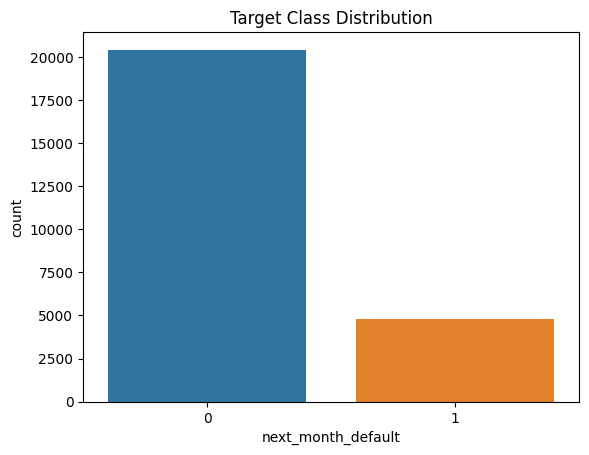

In [12]:
# 3. EDA
# Target Distribution
sns.countplot(x="next_month_default", data=train_df)
plt.title("Target Class Distribution"); plt.show()

In [13]:
# Summary statistics
print(train_df.describe())
print(train_df.corr()["next_month_default"].sort_values(ascending=False))


        Customer_ID      marriage           sex     education       LIMIT_BAL  \
count  25247.000000  25247.000000  25247.000000  25247.000000    25247.000000   
mean   17640.000000      1.551907      0.604111      1.852101   168342.060443   
std     7288.325459      0.522629      0.489050      0.797379   129892.784807   
min     5017.000000      0.000000      0.000000      0.000000    10000.000000   
25%    11328.500000      1.000000      0.000000      1.000000    50000.000000   
50%    17640.000000      2.000000      1.000000      2.000000   140000.000000   
75%    23951.500000      2.000000      1.000000      2.000000   240000.000000   
max    30263.000000      3.000000      1.000000      6.000000  1000000.000000   

                age         pay_0         pay_2         pay_3         pay_4  \
count  25121.000000  25247.000000  25247.000000  25247.000000  25247.000000   
mean      35.438199     -0.042857     -0.159544     -0.190359     -0.241415   
std        9.174998      1.099315

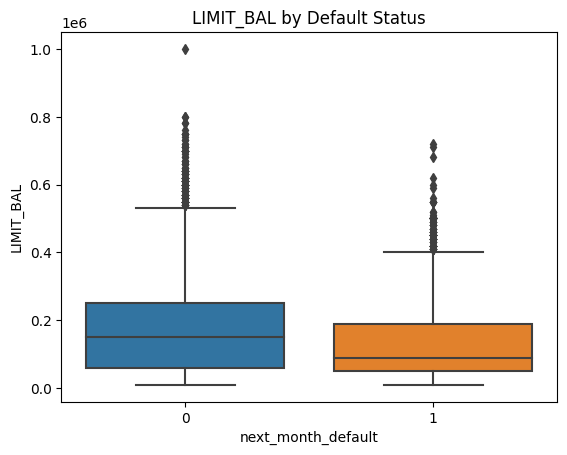

In [14]:
# Financial Insight Example
# Explore PAY_0, BILL_AMT1, LIMIT_BAL
sns.boxplot(x="next_month_default", y="LIMIT_BAL", data=train_df)
plt.title("LIMIT_BAL by Default Status"); plt.show()

In [15]:
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# Preprocessing
X = train_df.drop(columns=["next_month_default", "Customer_ID"])
y = train_df["next_month_default"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Class weight for imbalance
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model with class weight
from xgboost import XGBClassifier

model = XGBClassifier(scale_pos_weight=class_weights[1] / class_weights[0], use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
# 7. Evaluation with F2 Score
y_probs = model.predict_proba(X_test)[:, 1]


In [18]:
# Optimize threshold for best F2 Score
from sklearn.metrics import fbeta_score
thresholds = np.arange(0.1, 0.9, 0.01)
f2_scores = [fbeta_score(y_test, y_probs > t, beta=2) for t in thresholds]

best_threshold = thresholds[np.argmax(f2_scores)]
print(f"Best F2 threshold: {best_threshold:.2f}, F2 Score: {max(f2_scores):.4f}")

Best F2 threshold: 0.21, F2 Score: 0.5937


In [19]:
# Final Classification Report at optimal threshold
y_pred_opt = (y_probs > best_threshold).astype(int)
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.92      0.52      0.66      4095
           1       0.28      0.82      0.42       955

    accuracy                           0.57      5050
   macro avg       0.60      0.67      0.54      5050
weighted avg       0.80      0.57      0.62      5050



In [21]:
# 8. Predict on Validation Data
X_val_scaled = scaler.transform(val_df.drop(columns=["Customer_ID"]))
val_probs = model.predict_proba(X_val_scaled)[:, 1]
val_preds = (val_probs > best_threshold).astype(int)


In [22]:
submission = pd.DataFrame({
    "Customer": val_df["Customer_ID"],
    "next_month_default": val_preds
})
submission.to_csv("predictions.csv", index=False)
print(submission.head())


   Customer  next_month_default
0         1                   0
1         2                   0
2         3                   0
3         4                   1
4         5                   0


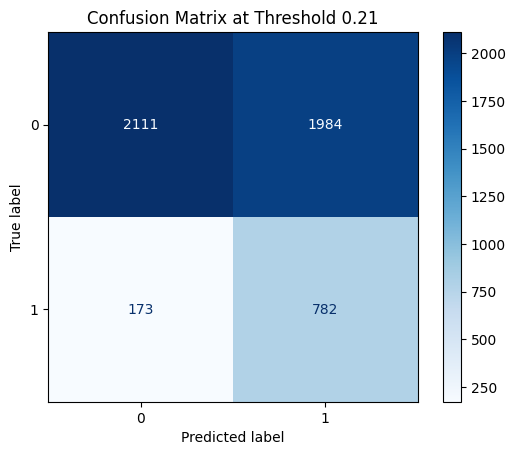

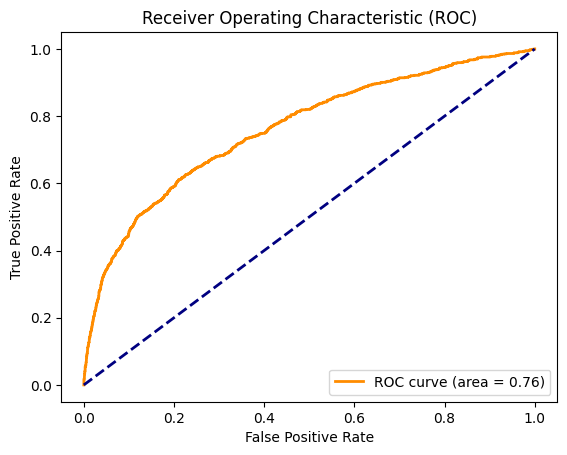

In [25]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test (true labels) and y_pred_proba (predicted probabilities) exist
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Confusion Matrix
from sklearn.metrics import classification_report
optimal_threshold = 0.21
y_pred = (y_pred_proba >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix at Threshold 0.21')
plt.savefig('Confusion Matrix at Threshold 0.21.png', dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('Receiver Operating Characteristic(ROC).png', dpi=300, bbox_inches='tight')
plt.show()